In [ ]:
#Import necessary libraries
import numpy as np
import sklearn as sl
import pandas as pd 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from google.colab import files
from math import sqrt
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler



In [ ]:
# The following code will mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## START PRE-PROCESSING

In [ ]:
# load dataset

train = pd.read_csv('/content/gdrive/MyDrive/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/test.csv')

'''
Merge the train and test data sets for standardization. 
'''
merged = train.append(test)


In [ ]:
'''
Take a peek. 
'''
merged.head(5)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74711 entries, 0 to 14942
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                74711 non-null  int64  
 1   age               74711 non-null  int64  
 2   class_worker      74711 non-null  object 
 3   det_ind_code      74711 non-null  int64  
 4   det_occ_code      74711 non-null  int64  
 5   education         74711 non-null  object 
 6   wage_per_hour     74711 non-null  int64  
 7   hs_college        74711 non-null  object 
 8   marital_stat      74711 non-null  object 
 9   major_ind_code    74711 non-null  object 
 10  major_occ_code    74711 non-null  object 
 11  race              74711 non-null  object 
 12  hisp_origin       74711 non-null  object 
 13  sex               74711 non-null  object 
 14  union_member      74711 non-null  object 
 15  unemp_reason      74711 non-null  object 
 16  full_or_part_emp  74711 non-null  object

In [ ]:
'''
NOT IN USE
'''

#test.columns = [c.replace(' ', '') for c in test.columns]
#train.columns = [c.replace(' ', '_') for c in train.columns]

#null_train_df = pd.DataFrame(train.isnull().sum())
#null_test_df = pd.DataFrame(test.isnull().sum())


'''
We see that there are a lot of missing values.
Can't fill these in with zeros - need to either use some averaging algorithm OR omit the feature(s) as a whole. 
'''
# Filter out all non-zeros 
#null_train_df = null_train_df[null_train_df[0] != 0]
#null_test_df = null_test_df[null_test_df[0] != 0]
#null_train_df.head(10)

"\nWe see that there are a lot of missing values.\nCan't fill these in with zeros - need to either use some averaging algorithm OR omit the feature(s) as a whole. \n"

In [ ]:
'''
We want to extract dummy variables for all categorical features for the merged set.
'''
#train_X = pd.get_dummies(train_X)
#val_X = pd.get_dummies(val_X)
merged = pd.get_dummies(merged)


''' NOT IN USE
We need the two data sets to be feature identical.
'''
#common_cols = train_X.columns.intersection(test_df.columns) # Get all the common features 
#train_X = train_X[common_cols]
#test_df = test_df[common_cols]

' NOT IN USE\nWe need the two data sets to be feature identical.\n'

In [ ]:
'''
Standardize the merged set.
'''
# First, we want to drop and save the id feature
merged_dropped = merged.drop(["id"], axis = 1)

# Now we can standardize merged_dropped 
scaler = StandardScaler()
col_names_merged = merged_dropped.columns
min_max_scaler = preprocessing.MinMaxScaler()
merged_final = min_max_scaler.fit_transform(merged_dropped)
merged_final = pd.DataFrame(merged_final, columns=col_names_merged)
merged_final.columns = [c.replace(' ', '_') for c in merged_final.columns] # There are weird spaces, so we want to replace those with _.
merged_final.columns = [c.replace('<', 'lt') for c in merged_final.columns] # xgb model can't process "<" in the feature names, so replace those.
'''
NOTE: We didn't drop the income variable because it is binary.
(e.g., it wont be affected by the standardization)
'''
merged_final

,age,det_ind_code,det_occ_code,wage_per_hour,capital_gains,capital_losses,stock_dividends,unknown,num_emp,own_or_self,vet_benefits,weeks_worked,year,income,class_worker__Federal_government,class_worker__Local_government,class_worker__Never_worked,class_worker__Not_in_universe,class_worker__Private,class_worker__Self-employed-incorporated,class_worker__Self-employed-not_incorporated,class_worker__State_government,class_worker__Without_pay,education__10th_grade,education__11th_grade,education__12th_grade_no_diploma,education__1st_2nd_3rd_or_4th_grade,education__5th_or_6th_grade,education__7th_and_8th_grade,education__9th_grade,education__Associates_degree-academic_program,education__Associates_degree-occup_/vocational,education__Bachelors_degree(BA_AB_BS),education__Children,education__Doctorate_degree(PhD_EdD),education__High_school_graduate,education__Less_than_1st_grade,education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA),education__Prof_school_degree_(MD_DDS_DVM_LLB_JD),education__Some_college_but_no_degree,...,country_self__Germany,country_self__Greece,country_self__Guatemala,country_self__Haiti,country_self__Holand-Netherlands,country_self__Honduras,country_self__Hong_Kong,country_self__Hungary,country_self__India,country_self__Iran,country_self__Ireland,country_self__Italy,country_self__Jamaica,country_self__Japan,country_self__Laos,country_self__Mexico,country_self__Nicaragua,country_self__Outlying-U_S_(Guam_USVI_etc),country_self__Panama,country_self__Peru,country_self__Philippines,country_self__Poland,country_self__Portugal,country_self__Puerto-Rico,country_self__Scotland,country_self__South_Korea,country_self__Taiwan,country_self__Thailand,country_self__Trinadad&Tobago,country_self__United-States,country_self__Vietnam,country_self__Yugoslavia,citizenship__Foreign_born-_Not_a_citizen_of_U_S_,citizenship__Foreign_born-_U_S_citizen_by_naturalization,citizenship__Native-_Born_abroad_of_American_Parent(s),citizenship__Native-_Born_in_Puerto_Rico_or_U_S_Outlying,citizenship__Native-_Born_in_the_United_States,vet_question__No,vet_question__Not_in_universe,vet_question__Yes
0,0.300000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.193313,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.355556,0.607843,0.565217,0.0,0.000000,0.0,0.0,0.015967,0.833333,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.488889,0.411765,0.565217,0.0,0.000000,0.0,0.0,0.131448,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.722222,0.882353,0.217391,0.0,0.072621,0.0,0.0,0.102069,0.166667,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.111111,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.024923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
'''
Split the merged set into training, validation, and test sets while isolating the outcome feature. 
'''
num_rows_train = int(len(train.index)) # Count the rows in the o.g. training set. 
num_rows_merged = int(len(merged_final.index)) # Count the rows in the merged set.
# Train
train_X = merged_final.loc[0:num_rows_train*.8,merged_final.columns != 'income'] 
train_Y = merged_final.loc[0:num_rows_train*.8,merged_final.columns == 'income'] 
# Validation
val_X = merged_final.loc[num_rows_train*.8:num_rows_train-1,merged_final.columns != 'income'] 
val_Y = merged_final.loc[num_rows_train*.8:num_rows_train-1,merged_final.columns == 'income'] 
# Test
test_X = merged_final.loc[num_rows_train:num_rows_merged,merged_final.columns != 'income'] 
test_id = pd.DataFrame(test["id"]) # Save the ID column for submission.
test_X = test_X.reset_index(drop = True)
# Full Training Set 
train_full_X = merged_final.loc[0:num_rows_train-1,merged_final.columns != "income"]
train_full_Y = merged_final.loc[0:num_rows_train-1,merged_final.columns == "income"]


## START MODELLING 

### Linear Regression

In [ ]:
'''
Linear Regression
'''
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
model = LinearRegression(fit_intercept=True)
#model = Ridge(alpha=0.0) # REGULARIZE
model.fit(train_X, train_Y)
pred = model.predict(val_X)
print(pred)
'''
The results are not binary.
This is a problem because we can't interpret the results.
We could make a threshold to turn each value to a binary value (e.g., if x < 0, then 0)
'''

[[ 0.33249283]
 [ 0.02360916]
 [-0.01525497]
 ...
 [ 0.44115067]
 [ 0.1515274 ]
 [-0.02789688]]


"\nThe results are not binary.\nThis is a problem because we can't interpret the results.\nWe could make a threshold to turn each value to a binary value (e.g., if x < 0, then 0)\n"

In [ ]:
'''
Try to convert the predicted values to binary values.
'''
pred_converted = []
for x in pred:
  if x < 0.3:
    pred_converted.append(0)
  else:
    pred_converted.append(1)


In [ ]:
'''
Measure performance of LinReg using AUC-ROC. 
'''
from sklearn.metrics import roc_auc_score
actual = np.array(val_Y["income"])
predicted = np.array(pred)
roc_auc_score(actual, predicted)


0.9278688226820082

### Logit

In [ ]:
num_columns = len(train_X.columns)
rfe_selector = RFE(estimator=LogisticRegression(max_iter=100), n_features_to_select = num_columns*.5, step = 5)
rfe_selector.fit(train_X, train_Y)
# Make new df with just the important features
cols = list(train_X.columns[rfe_selector.get_support()])
train_X_selected = train_X[cols]

In [ ]:
'''
Logistic Regression
'''
#model = LinearRegression(fit_intercept=True)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(train_X, train_Y)
pred = model.predict(val_X)
print(pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0. 0. 0. ... 0. 0. 0.]


In [ ]:
'''
Measure performance of Logit using AUC-ROC. 
'''
from sklearn.metrics import roc_auc_score
actual = np.array(val_Y["income"])
predicted = np.array(pred)
roc_auc_score(actual, predicted)


0.8158437751945895

### Xgboost

#### FEATURE SELECTION

In [ ]:
'''
SOURCE: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
'''

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

# fit model on all training data
model = XGBClassifier()
model.fit(train_X, train_Y)

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds_filtered = []
for x in thresholds:
  if x != 0.0:
    thresholds_filtered.append(x)
for thresh in thresholds_filtered:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	train_X_select = selection.transform(train_X)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(train_X_select, train_Y)
	# eval model
	val_X_select = selection.transform(val_X)
	pred = selection_model.predict(val_X_select)
	predicted = [round(value) for value in pred]
	actual = np.array(val_Y["income"])
	print("Thresh=%.5f, n=%d, Accuracy: %.5f%%" % (thresh, train_X_select.shape[1], roc_auc_score(actual, predicted)))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


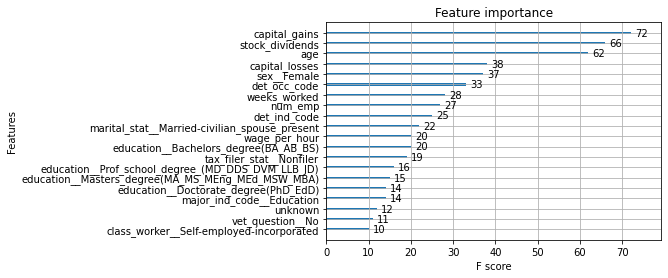

In [ ]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier()
model.fit(train_X, train_Y)
# plot feature importance
plot_importance(model, max_num_features = 20)
pyplot.show()

In [ ]:
model = XGBClassifier()
model.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Thresh=0.30477, n=30, Accuracy: 0.82627%


In [ ]:
for x in range(10,400,10):
  selection = SelectFromModel(model, max_features = x, prefit=True)
  train_X_select = selection.transform(train_X)
  # train model
  selection_model = XGBClassifier()
  selection_model.fit(train_X_select, train_Y)
  # eval model
  val_X_select = selection.transform(val_X)
  pred = selection_model.predict(val_X_select)
  predicted = [round(value) for value in pred]
  actual = np.array(val_Y["income"])
  print(x, roc_auc_score(actual, predicted))

'''
Feature selection did not improve the model. 
'''

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


390 0.8267691450534013


In [ ]:
'''
Choose features by importance.
'''
train_X_boost = train_X.loc[:,["capital_gains", "stock_dividends", "age", "capital_losses", 
                               "sex__Female", "det_occ_code", "weeks_worked", "num_emp",
                               "det_ind_code", "marital_stat__Married-civilian_spouse_present",
                               "wage_per_hour", "education__Bachelors_degree(BA_AB_BS)",
                               "tax_filer_stat__Nonfiler", "education__Prof_school_degree_(MD_DDS_DVM_LLB_JD)",
                               "education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA)", 
                               "education__Doctorate_degree(PhD_EdD)", "major_ind_code__Education"]]
val_X_boost = val_X.loc[:,["capital_gains", "stock_dividends", "age", "capital_losses", 
                               "sex__Female", "det_occ_code", "weeks_worked", "num_emp",
                               "det_ind_code", "marital_stat__Married-civilian_spouse_present",
                               "wage_per_hour", "education__Bachelors_degree(BA_AB_BS)",
                               "tax_filer_stat__Nonfiler", "education__Prof_school_degree_(MD_DDS_DVM_LLB_JD)",
                               "education__Masters_degree(MA_MS_MEng_MEd_MSW_MBA)", 
                               "education__Doctorate_degree(PhD_EdD)", "major_ind_code__Education"]]

#### XGBOOST MODEL

In [ ]:
'''
xgboost
Feature selection did not improve - this tells us that the model is not overfitting. 
'''
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(train_X, train_Y)
pred = xgb_model.predict(val_X)
print(pred)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0. 0. 0. ... 0. 0. 0.]


In [ ]:
'''
Measure performance of xgb using AUC-ROC. 
'''
from sklearn.metrics import roc_auc_score
actual = np.array(val_Y["income"])
predicted = np.array(pred)
roc_auc_score(actual, predicted) # o.g. score: 0.8279950082263784


0.8279950082263784

## EXPORT FINAL SUBMISSION

### PREDICT ON THE TEST SET 

In [ ]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(train_full_X, train_full_Y)
pred = xgb_model.predict(test_X)
print(pred)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1. 0. 0. ... 1. 0. 0.]


In [ ]:
'''
We have the predictions.
Need to make the final data set output. 
'''
final_dataset = pd.DataFrame([round(x) for x in pred], columns = ['income'])
final_dataset = pd.concat([test_id, final_dataset], axis = 1)
final_dataset = final_dataset[["id", "income"]]
final_dataset.head(10)
print(final_dataset)

          id  income
0      59768       1
1      59769       0
2      59770       0
3      59771       0
4      59772       0
...      ...     ...
14938  74706       0
14939  74707       0
14940  74708       1
14941  74709       0
14942  74710       0

[14943 rows x 2 columns]


In [ ]:
#This will export our previous table as a csv for submission.
final_dataset.to_csv('Submission_Project2_xgboost.csv', index = False )
from google.colab import files
files.download("Submission_Project2_xgboost.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>